<a href="https://colab.research.google.com/github/irandijunior1903/TCCAnaliseDeDados/blob/main/notebooks%20Colab/Analise_dos_dados_IDEB_(2019_PB)_Irandi_Jr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importando as bibliotecas necessárias


In [ ]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import sklearn.linear_model as lm

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.feature_selection import RFE
from numpy import array
from scipy import stats as st
from statsmodels.stats.outliers_influence import variance_inflation_factor
from yellowbrick.features import Rank2D

# Dados do IDEB 2019 (Escolas)

In [ ]:
# Lendo o arquivo do repositorio do GitHub
escolas_pb = pd.read_csv('https://raw.githubusercontent.com/irandijunior1903/dadosFiltradosTCC/main/dados_escolas_pb_ideb.csv')

In [ ]:
# Renomeando a coluna do id das escolas para o merge com os microdados do censo escolar
escolas_pb = escolas_pb.rename(columns={"ID_ESCOLA": "CO_ENTIDADE"})

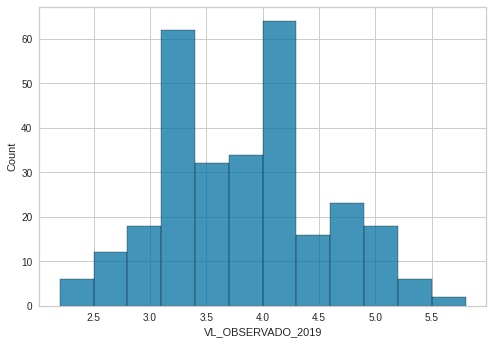

In [ ]:
# Plotando em contagem as notas do IDEB das escolas públicas da Paraíba
sns.histplot(data=escolas_pb, x="VL_OBSERVADO_2019", stat="count")

# Microdados do Censo Escolar 

In [ ]:
# Lendo o arquivo do repositorio do GitHub
microdados_pb = pd.read_csv('https://raw.githubusercontent.com/irandijunior1903/dadosFiltradosTCC/main/microdados_censo_pb.csv')

# Junção dos conjuntos de dados e filtragem de valores NaN

In [ ]:
# Fazendo o merge entre os dataframes de escolas com os microdados do censo, as quais tem o código da escola em comum
dados_merge = pd.merge(escolas_pb, microdados_pb, on='CO_ENTIDADE')
dados_merge = dados_merge.drop(columns='Unnamed: 0_x')

# Exibindo as colunas por quantidade de valores 'NaN'
dados_merge.isna().sum().sort_values(ascending=False).head(45)

IN_MATERIAL_ESP_NAO_UTILIZA      293
IN_MATERIAL_PED_NENHUM           293
IN_AGUA_FILTRADA                 293
IN_ENERGIA_GERADOR               293
IN_ENERGIA_OUTROS                293
IN_FINAL_SEMANA                  293
IN_BRASIL_ALFABETIZADO           293
IN_LIXO_JOGA_OUTRA_AREA          293
IN_LIXO_OUTROS                   293
IN_LIXO_RECICLA                  293
IN_MATERIAL_ESP_INDIGENA         293
IN_MATERIAL_ESP_QUILOMBOLA       293
IN_BANHEIRO_FORA_PREDIO          293
IN_LOCAL_FUNC_TEMPLO_IGREJA      293
IN_BANHEIRO_DENTRO_PREDIO        293
IN_BERCARIO                      293
IN_PROF_ASSIST_SOCIAL            293
IN_PROF_GESTAO                   293
IN_DEPENDENCIAS_PNE              293
IN_LAVANDERIA                    293
IN_EQUIP_FOTO                    293
IN_EQUIP_FAX                     293
IN_EQUIP_RETROPROJETOR           293
IN_EQUIP_VIDEOCASSETE            293
IN_LOCAL_FUNC_CASA_PROFESSOR     293
IN_EQUIP_NENHUM                  293
IN_MANT_ESCOLA_PRIVADA_EMP       293
I

In [ ]:
#Removendo as colunas com pelo menos 1 NaN
dm = dados_merge.dropna(axis=1, how='any')
dm.isna().sum().sort_values(ascending=False)

SG_UF                         0
IN_MATERIAL_PED_MULTIMIDIA    0
IN_PROF_ADMINISTRATIVOS       0
IN_PROF_SERVICOS_GERAIS       0
IN_PROF_BIBLIOTECARIO         0
                             ..
IN_LABORATORIO_INFORMATICA    0
IN_PATIO_COBERTO              0
IN_PATIO_DESCOBERTO           0
IN_PARQUE_INFANTIL            0
IN_ESP_CE                     0
Length: 178, dtype: int64

#T-test das variáveis do Censo em relação a nota do Ideb

In [ ]:
# Função para realizar o t-test com colunas específicas
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df_numeric = dm.select_dtypes(include=numerics)
compare_cols = df_numeric.columns
df = pd.DataFrame(data=df_numeric)               
def all_pairwise(df, compare_cols, col='VL_OBSERVADO_2019'):
  list_of_dfs = []
  for compare_col in compare_cols:
    v0 = df[df[compare_col] == 0][col]
    v1 = df[df[compare_col] == 1][col]
    n = len(v0.index) + len(v1.index)
    prop_v1 = 0 if n == 0 else len(v1.index) / n
    results = st.ttest_ind(v0, v1, nan_policy='omit')
    tmp = pd.DataFrame({
      'mean_v0': v0.mean(),
      'mean_v1': v1.mean(),
      'propv1': prop_v1,
      'tstat': results.statistic,
      'pvalue': results.pvalue}, index = [compare_col])
    if 0.10 < prop_v1 < 0.90 and results.pvalue <= 0.05:
     list_of_dfs.append(tmp)
  df_stats = pd.concat(list_of_dfs)
  return df_stats

df_stats = all_pairwise(df, compare_cols)
df_stats.sort_values(['pvalue'], ascending=True)

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,mean_v0,mean_v1,propv1,tstat,pvalue
IN_NOTURNO,4.183607,3.733190,0.791809,4.673058,0.000005
IN_LABORATORIO_CIENCIAS,3.669595,3.987586,0.494881,-4.025919,0.000072
IN_PROF_PEDAGOGIA,3.625225,3.950000,0.621160,-3.987457,0.000085
IN_EJA,4.093243,3.736986,0.747440,3.913866,0.000113
IN_QUADRA_ESPORTES_COBERTA,3.719337,4.000893,0.382253,-3.439791,0.000667
IN_EJA_MED,4.042500,3.746009,0.726962,3.316396,0.001028
IN_PROF_TEC,3.769388,4.120833,0.163823,-3.263876,0.001230
IN_PROF,3.768619,4.085185,0.184300,-3.073708,0.002315
IN_PROF_BIBLIOTECARIO,3.693846,3.933129,0.556314,-2.974015,0.003185
IN_LABORATORIO_INFORMATICA,3.546512,3.875200,0.853242,-2.907857,0.003919


# Correlações entre as Notas do Ideb com variáveis do Censo

In [ ]:
#Exibindo as correlações absolutas mais significantes
compare_cols = dm[df_stats.T.columns]
df = pd.DataFrame(data=dm)               
def calc_corr(df, compare_cols, col='VL_OBSERVADO_2019'):
  list_of_dfs = []
  for compare_col in compare_cols:
    tmp = pd.DataFrame({
      'corr': df[col].corr(df[compare_col]),
      'corr_abs':abs(df[col].corr(df[compare_col]))}, index = [compare_col])
    if abs(df[col].corr(df[compare_col])) > 0.10:
     list_of_dfs.append(tmp)
  df_corr = pd.concat(list_of_dfs)
  return df_corr

df_corr = calc_corr(df, compare_cols)
df_corr.sort_values(['corr_abs'], ascending=False)

,corr,corr_abs
IN_NOTURNO,-0.264205,0.264205
IN_LABORATORIO_CIENCIAS,0.229694,0.229694
IN_PROF_PEDAGOGIA,0.227613,0.227613
IN_EJA,-0.223625,0.223625
IN_QUADRA_ESPORTES_COBERTA,0.197666,0.197666
IN_EJA_MED,-0.190838,0.190838
IN_PROF_TEC,0.187923,0.187923
IN_PROF,0.177328,0.177328
IN_PROF_BIBLIOTECARIO,0.171749,0.171749
IN_LABORATORIO_INFORMATICA,0.168038,0.168038


# Detectando as variáveis que possuem multicolinearidade

In [ ]:
# VIF dataframe (Detecting multicollinearity)
vif_data = pd.DataFrame()
filter_col_corr = [col for col in df_corr.T]
data_multicollinearity = dm[filter_col_corr]

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = data_multicollinearity.columns

  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(data_multicollinearity.values, i)
                   for i in range(len(data_multicollinearity.columns))]
                          
print(vif_data)

                           feature        VIF
0                     IN_AUDITORIO   1.654867
1                    IN_BIBLIOTECA  25.432434
2       IN_BIBLIOTECA_SALA_LEITURA  27.356921
3          IN_LABORATORIO_CIENCIAS   2.613937
4       IN_LABORATORIO_INFORMATICA   6.885575
5               IN_QUADRA_ESPORTES   5.646881
6       IN_QUADRA_ESPORTES_COBERTA   4.284071
7                    IN_REFEITORIO   1.989037
8              IN_EQUIP_IMPRESSORA   2.674110
9   IN_ACES_INTERNET_DISP_PESSOAIS   1.498897
10           IN_PROF_BIBLIOTECARIO   3.415287
11             IN_PROF_COORDENADOR   1.474453
12               IN_PROF_PEDAGOGIA   3.120377
13              IN_PROF_SECRETARIO   7.363944
14               IN_PROF_MONITORES   1.833197
15                      IN_NOTURNO  12.098258
16                         IN_FUND  87.816502
17                      IN_FUND_AF  84.171069
18                         IN_PROF  10.066451
19                     IN_PROF_TEC  10.013104
20                          IN_EJA

## Analisando algumas variáveis mais a fundo

### IN_FUND

In [ ]:
dm_corr = dm[df_stats.T.columns].corr()
dm_corr['IN_FUND'].abs().sort_values(ascending=False).head(10)

IN_FUND                           1.000000
IN_FUND_AF                        0.986433
IN_EJA_FUND                       0.433730
IN_EJA                            0.272910
IN_EJA_MED                        0.219393
IN_NOTURNO                        0.218244
IN_PROF                           0.185570
IN_PROF_TEC                       0.176900
IN_ACES_INTERNET_DISP_PESSOAIS    0.141588
IN_EQUIP_IMPRESSORA               0.125643
Name: IN_FUND, dtype: float64

### IN_BIBLIOTECA

In [ ]:
dm_corr = dm[df_stats.T.columns].corr()
dm_corr['IN_BIBLIOTECA'].abs().sort_values(ascending=False).head(10)

IN_BIBLIOTECA                 1.000000
IN_BIBLIOTECA_SALA_LEITURA    0.881494
IN_PROF_BIBLIOTECARIO         0.425220
IN_LABORATORIO_CIENCIAS       0.309771
IN_QUADRA_ESPORTES            0.262358
IN_LABORATORIO_INFORMATICA    0.224666
IN_AUDITORIO                  0.215566
IN_QUADRA_ESPORTES_COBERTA    0.202338
IN_REFEITORIO                 0.200878
IN_PROF_MONITORES             0.165106
Name: IN_BIBLIOTECA, dtype: float64

### IN_NOTURNO

In [ ]:
dm_corr = dm[df_stats.T.columns].corr()
dm_corr['IN_NOTURNO'].abs().sort_values(ascending=False).head(10)

IN_NOTURNO                    1.000000
IN_EJA                        0.766035
IN_EJA_MED                    0.761221
IN_EJA_FUND                   0.286312
IN_FUND_AF                    0.228132
IN_FUND                       0.218244
IN_QUADRA_ESPORTES_COBERTA    0.167495
IN_QUADRA_ESPORTES            0.160852
IN_PROF_TEC                   0.136427
IN_AUDITORIO                  0.116345
Name: IN_NOTURNO, dtype: float64

### IN_PROF

In [ ]:
dm_corr = dm[df_stats.T.columns].corr()
dm_corr['IN_PROF'].abs().sort_values(ascending=False).head(10)

IN_PROF                       1.000000
IN_PROF_TEC                   0.931193
IN_AUDITORIO                  0.259961
IN_LABORATORIO_CIENCIAS       0.198531
IN_FUND_AF                    0.196751
IN_QUADRA_ESPORTES_COBERTA    0.187635
IN_FUND                       0.185570
IN_REFEITORIO                 0.169609
IN_EJA                        0.169407
IN_EJA_MED                    0.163119
Name: IN_PROF, dtype: float64

### IN_QUADRA_ESPORTES

In [ ]:
dm_corr = dm[df_stats.T.columns].corr()
dm_corr['IN_QUADRA_ESPORTES'].abs().sort_values(ascending=False).head(10)

IN_QUADRA_ESPORTES            1.000000
IN_QUADRA_ESPORTES_COBERTA    0.762826
IN_BIBLIOTECA                 0.262358
IN_PROF_BIBLIOTECARIO         0.261123
IN_AUDITORIO                  0.258109
IN_PROF_PEDAGOGIA             0.242207
IN_LABORATORIO_CIENCIAS       0.235933
IN_BIBLIOTECA_SALA_LEITURA    0.216569
IN_PROF_MONITORES             0.195026
IN_REFEITORIO                 0.177131
Name: IN_QUADRA_ESPORTES, dtype: float64

### IN_PROF_SECRETARIO

In [ ]:
dm_corr = dm[df_stats.T.columns].corr()
dm_corr['IN_PROF_SECRETARIO'].abs().sort_values(ascending=False).head(10)

IN_PROF_SECRETARIO            1.000000
IN_PROF_BIBLIOTECARIO         0.227784
IN_PROF_MONITORES             0.166617
IN_BIBLIOTECA                 0.160812
IN_BIBLIOTECA_SALA_LEITURA    0.158502
IN_LABORATORIO_INFORMATICA    0.126981
IN_REFEITORIO                 0.100101
IN_EJA_MED                    0.082647
IN_EJA                        0.079560
IN_PROF                       0.078691
Name: IN_PROF_SECRETARIO, dtype: float64

### IN_LABORATORIO_INFORMATICA

In [ ]:
dm_corr = dm[df_stats.T.columns].corr()
dm_corr['IN_LABORATORIO_INFORMATICA'].abs().sort_values(ascending=False).head(10)

IN_LABORATORIO_INFORMATICA    1.000000
IN_LABORATORIO_CIENCIAS       0.236887
IN_BIBLIOTECA                 0.224666
IN_PROF_MONITORES             0.211015
IN_BIBLIOTECA_SALA_LEITURA    0.181258
IN_PROF_BIBLIOTECARIO         0.153782
IN_PROF_SECRETARIO            0.126981
IN_PROF_PEDAGOGIA             0.113526
IN_REFEITORIO                 0.082133
IN_PROF                       0.072758
Name: IN_LABORATORIO_INFORMATICA, dtype: float64

# Excluindo as variáveis que possuem multicolinearidade

In [ ]:
# Excluindo as features multicorrelacionadas
vif_data.drop(vif_data[(vif_data['feature'] == 'IN_PROF_TEC') | (vif_data['feature'] == 'IN_QUADRA_ESPORTES')
| (vif_data['feature'] == 'IN_FUND_AF') | (vif_data['feature'] == 'IN_BIBLIOTECA_SALA_LEITURA')
| (vif_data['feature'] == 'IN_EJA') | (vif_data['feature'] == 'IN_EJA_MED')].index, inplace=True)

In [ ]:
# Separando as features filtradas no VIF para calcular o Intervalo de Confiança
vif_data_corr = calc_corr(dm, vif_data.feature)
print(vif_data_corr.sort_values('corr_abs', ascending=False))

                                    corr  corr_abs
IN_NOTURNO                     -0.264205  0.264205
IN_LABORATORIO_CIENCIAS         0.229694  0.229694
IN_PROF_PEDAGOGIA               0.227613  0.227613
IN_QUADRA_ESPORTES_COBERTA      0.197666  0.197666
IN_PROF                         0.177328  0.177328
IN_PROF_BIBLIOTECARIO           0.171749  0.171749
IN_LABORATORIO_INFORMATICA      0.168038  0.168038
IN_REFEITORIO                   0.157515  0.157515
IN_AUDITORIO                    0.154952  0.154952
IN_FUND                        -0.139884  0.139884
IN_EJA_FUND                    -0.139601  0.139601
IN_EQUIP_IMPRESSORA             0.135257  0.135257
IN_ACES_INTERNET_DISP_PESSOAIS  0.134343  0.134343
IN_PROF_SECRETARIO             -0.127325  0.127325
IN_PROF_COORDENADOR             0.125753  0.125753
IN_BIBLIOTECA                   0.124073  0.124073
IN_PROF_MONITORES               0.119018  0.119018


# Intervalo de Confiança

In [ ]:
#Calculando o intervalo de confiança
confidence = 0.95
mean = dm['VL_OBSERVADO_2019'].mean()
count = len(dm)
std_error = dm['VL_OBSERVADO_2019'].sem()

ci = st.t.interval(confidence, count - 1, loc=mean, scale=std_error)

Text(0.5, 1.0, 'IN_ACES_INTERNET_DISP_PESSOAIS')

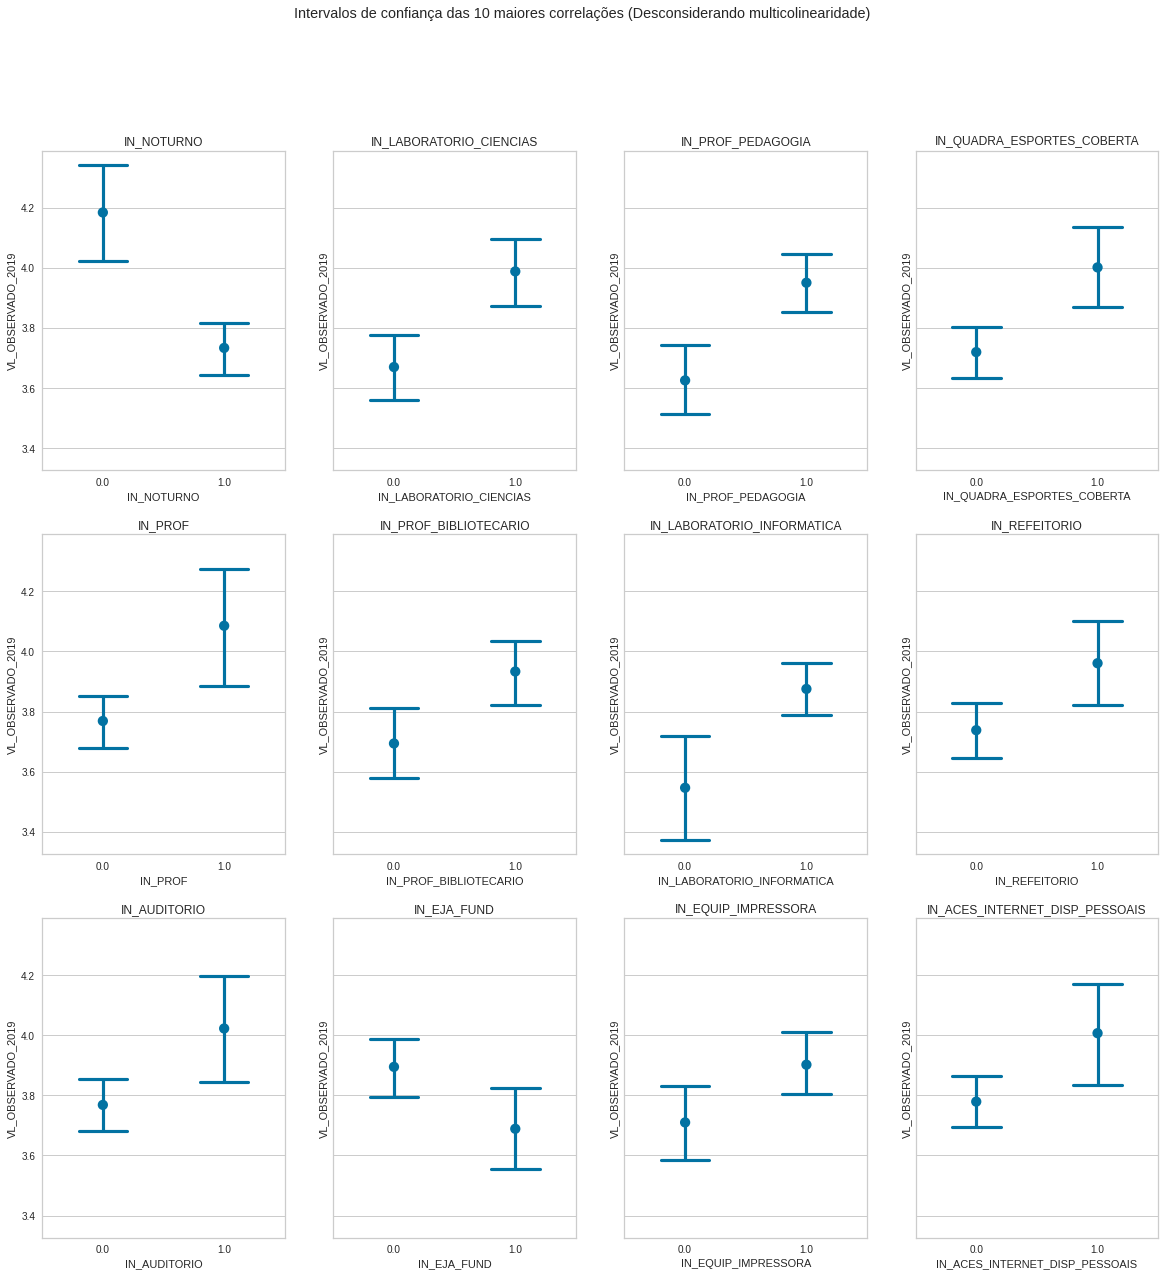

In [ ]:
# Subplots dos intervalos de confiança das variáveis filtradas
fig, axes = plt.subplots(3, 4, figsize=(20, 20), sharey=True)
fig.suptitle('Intervalos de confiança das 10 maiores correlações (Desconsiderando multicolinearidade)')

sns.pointplot(ax=axes[0,0], x=dm['IN_NOTURNO'], y=dm['VL_OBSERVADO_2019'], 
              errorbar = ('ci', confidence), join=False, capsize=.4)
axes[0,0].set_title(dm['IN_NOTURNO'].name)

sns.pointplot(ax=axes[0,1], x=dm['IN_LABORATORIO_CIENCIAS'], y=dm['VL_OBSERVADO_2019'], 
              errorbar = ('ci', confidence), join=False, capsize=.4)
axes[0,1].set_title(dm['IN_LABORATORIO_CIENCIAS'].name)

sns.pointplot(ax=axes[0,2], x=dm['IN_PROF_PEDAGOGIA'], y=dm['VL_OBSERVADO_2019'], 
              errorbar = ('ci', confidence), join=False, capsize=.4)
axes[0,2].set_title(dm['IN_PROF_PEDAGOGIA'].name)

sns.pointplot(ax=axes[0,3], x=dm['IN_QUADRA_ESPORTES_COBERTA'], y=dm['VL_OBSERVADO_2019'], 
              errorbar = ('ci', confidence), join=False, capsize=.4)
axes[0,3].set_title(dm['IN_QUADRA_ESPORTES_COBERTA'].name)

sns.pointplot(ax=axes[1,0], x=dm['IN_PROF'], y=dm['VL_OBSERVADO_2019'], 
              errorbar = ('ci', confidence), join=False, capsize=.4)
axes[1,0].set_title(dm['IN_PROF'].name)

sns.pointplot(ax=axes[1,1], x=dm['IN_PROF_BIBLIOTECARIO'], y=dm['VL_OBSERVADO_2019'], 
              errorbar = ('ci', confidence), join=False, capsize=.4)
axes[1,1].set_title(dm['IN_PROF_BIBLIOTECARIO'].name)

sns.pointplot(ax=axes[1,2], x=dm['IN_LABORATORIO_INFORMATICA'], y=dm['VL_OBSERVADO_2019'], 
              errorbar = ('ci', confidence), join=False, capsize=.4)
axes[1,2].set_title(dm['IN_LABORATORIO_INFORMATICA'].name)

sns.pointplot(ax=axes[1,3], x=dm['IN_REFEITORIO'], y=dm['VL_OBSERVADO_2019'], 
              errorbar = ('ci', confidence), join=False, capsize=.4)
axes[1,3].set_title(dm['IN_REFEITORIO'].name)

sns.pointplot(ax=axes[2,0], x=dm['IN_AUDITORIO'], y=dm['VL_OBSERVADO_2019'], 
              errorbar = ('ci', confidence), join=False, capsize=.4)
axes[2,0].set_title(dm['IN_AUDITORIO'].name)

sns.pointplot(ax=axes[2,1], x=dm['IN_EJA_FUND'], y=dm['VL_OBSERVADO_2019'], 
              errorbar = ('ci', confidence), join=False, capsize=.4)
axes[2,1].set_title(dm['IN_EJA_FUND'].name)

sns.pointplot(ax=axes[2,2], x=dm['IN_EQUIP_IMPRESSORA'], y=dm['VL_OBSERVADO_2019'], 
              errorbar = ('ci', confidence), join=False, capsize=.4)
axes[2,2].set_title(dm['IN_EQUIP_IMPRESSORA'].name)

sns.pointplot(ax=axes[2,3], x=dm['IN_ACES_INTERNET_DISP_PESSOAIS'], y=dm['VL_OBSERVADO_2019'], 
              errorbar = ('ci', confidence), join=False, capsize=.4)
axes[2,3].set_title(dm['IN_ACES_INTERNET_DISP_PESSOAIS'].name)

# Regressão Linear

## Para todas as variáveis binárias do Censo, filtrar as que estão dentro da proporção

In [ ]:
# Função para filtrar as variáveis do Censo dentro da proporção aceitada:
# colunas com valores 0 ou 1 maiores que 10% e menores que 90% do total de dados da coluna
compare_cols = dm.columns
df = pd.DataFrame(data=dm)               
def rfe_features(df, compare_cols, col='VL_OBSERVADO_2019'):
  list_of_dfs = []
  for compare_col in compare_cols:
    v0 = df[df[compare_col] == 0][col]
    v1 = df[df[compare_col] == 1][col]
    n = len(v0.index) + len(v1.index)
    prop_v1 = 0 if n == 0 else len(v1.index) / n
    tmp = pd.DataFrame({
      'columns': compare_col}, index=[compare_col])
    if 0.10 < prop_v1 < 0.90:
     list_of_dfs.append(tmp)
  df_features = pd.concat(list_of_dfs)
  return df_features
df_features = rfe_features(df, compare_cols)
df_transpose = df_features.T
filter_col = [col for col in df_transpose if col.startswith('IN')]

In [ ]:
# Selecinando os dados para verificar a regressão em relação a nota do IDEB
X = dm[filter_col]
y = dm['VL_OBSERVADO_2019']

In [ ]:
# Criando o modelo de regressão linear
regression_all = lm.LinearRegression()
estimator = regression_all

Text(0.5, 1.0, 'Regressão Linear')

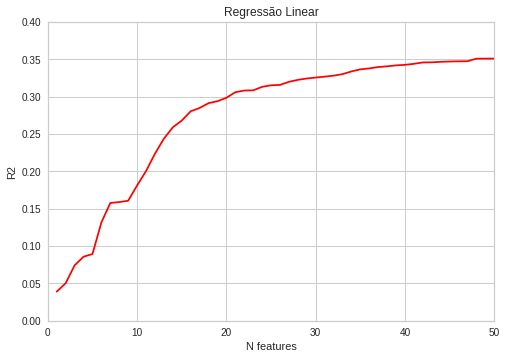

In [ ]:
# Executando o RFE para todas as colunas em X
scores = []
n_features_lst = range(1, len(X.columns))
for n_features in n_features_lst:
  selector = RFE(estimator, n_features_to_select=n_features, step=1)
  selector = selector.fit(X, y)
  filter = selector.support_
  scores.append(selector.score(X, y))
  

plt.plot(n_features_lst, scores, color='red')
plt.xlabel("N features")
plt.ylabel("R2")
plt.ylim([0, 0.4])
plt.xlim([0, 50])
plt.title("Regressão Linear")

## Para as variáveis filtradas desde o teste-t até a multicolinearidade

In [ ]:
# Executando o RFE para as variáveis filtradas desde o teste-t até a multicolinearidade
X_filter = X[vif_data.feature]
selector_filter = RFE(estimator, n_features_to_select=len(X_filter), step=1)
selector_filter = selector_filter.fit(X_filter, y)
filter = selector_filter.support_
ranking = selector_filter.ranking_
print(filter)
print(ranking)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [ ]:
# Exibindo as colunas com melhores resultados no RFE das variáveis filtradas
features = array(X_filter.columns)
print(features[filter])

['IN_AUDITORIO' 'IN_BIBLIOTECA' 'IN_LABORATORIO_CIENCIAS'
 'IN_LABORATORIO_INFORMATICA' 'IN_QUADRA_ESPORTES_COBERTA' 'IN_REFEITORIO'
 'IN_EQUIP_IMPRESSORA' 'IN_ACES_INTERNET_DISP_PESSOAIS'
 'IN_PROF_BIBLIOTECARIO' 'IN_PROF_COORDENADOR' 'IN_PROF_PEDAGOGIA'
 'IN_PROF_SECRETARIO' 'IN_PROF_MONITORES' 'IN_NOTURNO' 'IN_FUND' 'IN_PROF'
 'IN_EJA_FUND']


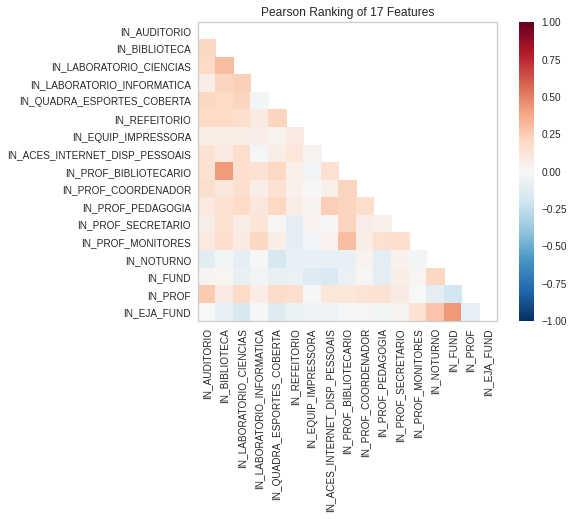

In [ ]:
# Visualizando o rank das variáveis filtradas com Rank2D
features_rank = dm[X_filter.columns]
visualizer = Rank2D(algorithm='pearson')
visualizer.fit(features_rank, y)           # Fit the data to the visualizer
visualizer.transform(features_rank)        # Transform the data
visualizer.show()

In [ ]:
# Exibindo o R2 calculado para as variáveis filtradas
score = selector_filter.score(X_filter, y)
print(score)

0.2265133969346228


# Utilizando o OLS (Ordinary Least Squares) para a Regressão Linear

## Para todas as variáveis binárias do Censo, filtrar as que estão dentro da proporção

In [ ]:
#Utilizando o stat models para gerar as métricas
x = sm.add_constant(X)
results = sm.OLS(y, x).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:      VL_OBSERVADO_2019   R-squared:                       0.366
Model:                            OLS   Adj. R-squared:                  0.143
Method:                 Least Squares   F-statistic:                     1.639
Date:                Wed, 14 Dec 2022   Prob (F-statistic):            0.00306
Time:                        19:11:27   Log-Likelihood:                -241.24
No. Observations:                 293   AIC:                             636.5
Df Residuals:                     216   BIC:                             919.8
Df Model:                          76                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


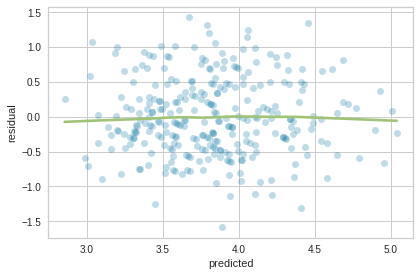

In [ ]:
# Gráfico dos resíduos
fig, ax = plt.subplots(figsize=(6, 4))
sns.regplot(x=results.fittedvalues, y=results.resid, 
            scatter_kws={'alpha': 0.25},
            line_kws={'color': 'C1'},
            lowess=True, ax=ax)
ax.set_xlabel('predicted')
ax.set_ylabel('residual')

plt.tight_layout()
plt.show()

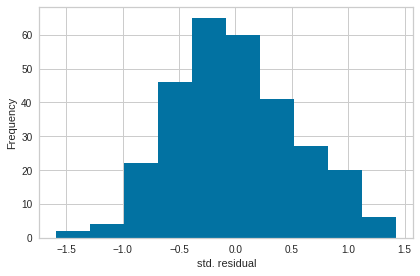

In [ ]:
# Distribuição dos resíduos
fig, ax = plt.subplots(figsize=(6, 4))
pd.Series(results.resid).hist(ax=ax)
ax.set_xlabel('std. residual')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## Para as variáveis filtradas desde o teste-t até a multicolinearidade

In [ ]:
#Calculando a regressão com stat models para o dataset das variáveis filtradas no teste-t
x_filter = sm.add_constant(X_filter)
results_filter = sm.OLS(y, x_filter).fit()
print(results_filter.summary())

                            OLS Regression Results                            
Dep. Variable:      VL_OBSERVADO_2019   R-squared:                       0.227
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     4.737
Date:                Tue, 13 Dec 2022   Prob (F-statistic):           7.95e-09
Time:                        17:30:25   Log-Likelihood:                -270.32
No. Observations:                 293   AIC:                             576.6
Df Residuals:                     275   BIC:                             642.9
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


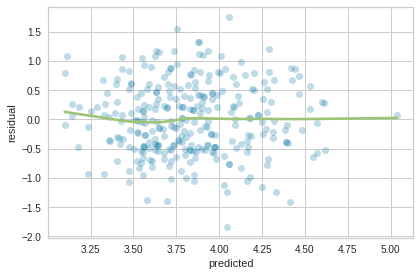

In [ ]:
# Gráfico de resíduos
fig, ax = plt.subplots(figsize=(6, 4))
sns.regplot(x=results_filter.fittedvalues, y=results_filter.resid, 
            scatter_kws={'alpha': 0.25},
            line_kws={'color': 'C1'},
            lowess=True, ax=ax)
ax.set_xlabel('predicted')
ax.set_ylabel('residual')

plt.tight_layout()
plt.show()

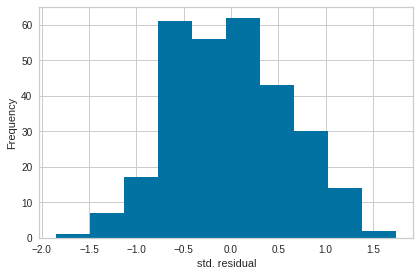

In [ ]:
# Distribuição dos resíduos
fig, ax = plt.subplots(figsize=(6, 4))
pd.Series(results_filter.resid).hist(ax=ax)
ax.set_xlabel('std. residual')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Importância dos coeficientes das variáveis filtradas no modelo de Regressão Linear

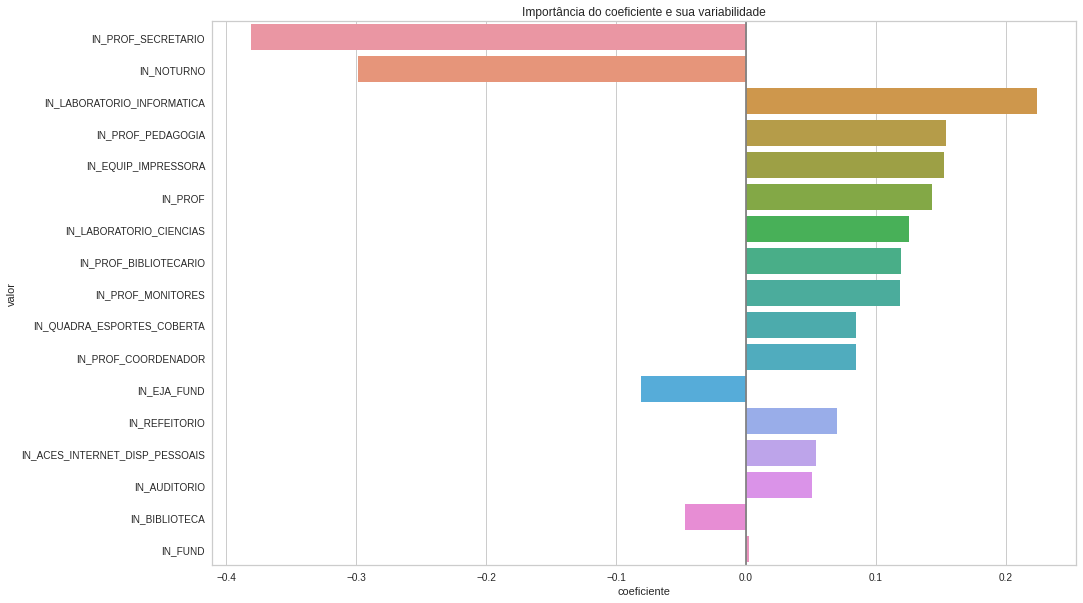

In [ ]:
# Importância dos coeficientes das variáveis filtradas
model_all = regression_all.fit(X_filter, y)
coefs = pd.DataFrame({
   'coeficiente': model_all.coef_,
   'coef_abs': abs(model_all.coef_),
   'valor': X_filter.columns
}).sort_values(['coef_abs'], ascending=False)
plt.figure(figsize=(20, 10))
sns.barplot(data=coefs, y='valor', x='coeficiente')
plt.axvline(x=0, color='.5')
plt.title('Importância do coeficiente e sua variabilidade')
plt.subplots_adjust(left=.3)